<a href="https://colab.research.google.com/github/Blackcipher101/ASL-detector/blob/main/ASLdetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [1]:
!mkdir .kaggle

In [2]:
import json
token = {"username":"nehalnevle","key":"f56fbefc794d7437f2952910cd1d058d"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [3]:
!mkdir /root/.kaggle

In [4]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [5]:
!kaggle config set -n path -v/content

- path is now set to: /content


In [6]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

In [7]:
!kaggle datasets download -d grassknoted/asl-alphabet

 98% 1.01G/1.03G [00:24<00:00, 39.1MB/s]
100% 1.03G/1.03G [00:24<00:00, 44.4MB/s]


In [8]:
!unzip '/content/datasets/grassknoted/asl-alphabet/*.zip' 

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing191.jpg  
  inflating: asl_alphabet_t

In [34]:
import os
import numpy as np
import glob
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import logging
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
logger=tf.get_logger()
logger.setLevel(logging.ERROR)

In [10]:
base_dir = '/content/asl_alphabet_train/asl_alphabet_train'
classes = ['A', 'B', 'C', 'D', 'E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  print(img_path)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

/content/asl_alphabet_train/asl_alphabet_train/A
A: 3000 Images
/content/asl_alphabet_train/asl_alphabet_train/B
B: 3000 Images
/content/asl_alphabet_train/asl_alphabet_train/C
C: 3000 Images
/content/asl_alphabet_train/asl_alphabet_train/D
D: 3000 Images
/content/asl_alphabet_train/asl_alphabet_train/E
E: 3000 Images
/content/asl_alphabet_train/asl_alphabet_train/F
F: 3000 Images
/content/asl_alphabet_train/asl_alphabet_train/G
G: 3000 Images
/content/asl_alphabet_train/asl_alphabet_train/H
H: 3000 Images
/content/asl_alphabet_train/asl_alphabet_train/I
I: 3000 Images
/content/asl_alphabet_train/asl_alphabet_train/J
J: 3000 Images
/content/asl_alphabet_train/asl_alphabet_train/K
K: 3000 Images
/content/asl_alphabet_train/asl_alphabet_train/L
L: 3000 Images
/content/asl_alphabet_train/asl_alphabet_train/M
M: 3000 Images
/content/asl_alphabet_train/asl_alphabet_train/N
N: 3000 Images
/content/asl_alphabet_train/asl_alphabet_train/O
O: 3000 Images
/content/asl_alphabet_train/asl_alphabet

In [11]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

In [12]:
batch_size = 100
IMG_SHAPE = 200

In [13]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_SHAPE = 224

In [49]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    )


train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(200,200),
                                                class_mode='sparse'
                                                )

Found 62400 images belonging to 26 classes.


In [50]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

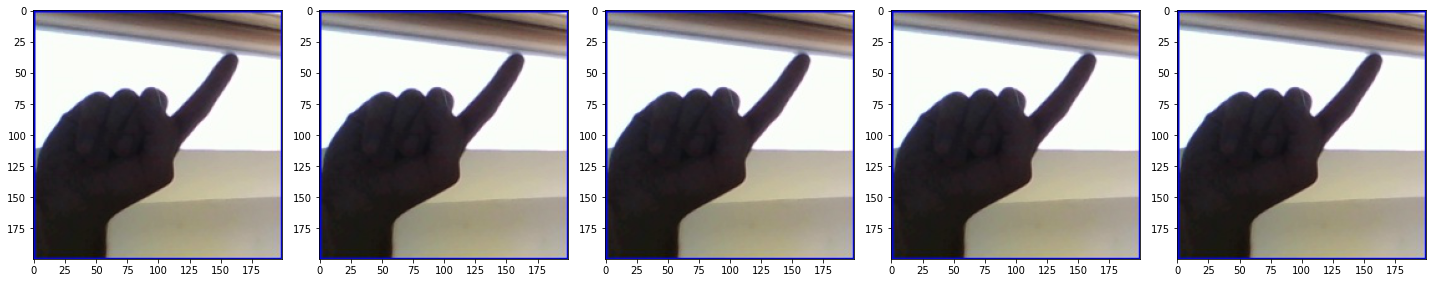

In [51]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [52]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(200,200),
                                                 class_mode='sparse')

Found 15600 images belonging to 26 classes.


In [53]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(224, 224,3))

In [54]:
feature_extractor.trainable = False

In [57]:
model = Sequential()

model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(200,200, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(26,activation='softmax'))
    

In [58]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [59]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 200, 200, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 40000)            

In [70]:
epochs = 6

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size)))
)

Epoch 1/6
624/624 [==============================] - 112s 179ms/step - loss: 2.4896 - accuracy: 0.8333 - val_loss: 2.4598 - val_accuracy: 0.8633
Epoch 2/6
624/624 [==============================] - 109s 174ms/step - loss: 2.4646 - accuracy: 0.8582 - val_loss: 2.4512 - val_accuracy: 0.8715
Epoch 3/6
624/624 [==============================] - 109s 175ms/step - loss: 2.4573 - accuracy: 0.8656 - val_loss: 2.4526 - val_accuracy: 0.8704
Epoch 4/6
624/624 [==============================] - 108s 174ms/step - loss: 2.4521 - accuracy: 0.8704 - val_loss: 2.4545 - val_accuracy: 0.8679
Epoch 5/6
624/624 [==============================] - 108s 172ms/step - loss: 2.4494 - accuracy: 0.8730 - val_loss: 2.4454 - val_accuracy: 0.8769
Epoch 6/6
624/624 [==============================] - 107s 172ms/step - loss: 2.4477 - accuracy: 0.8746 - val_loss: 2.4469 - val_accuracy: 0.8753


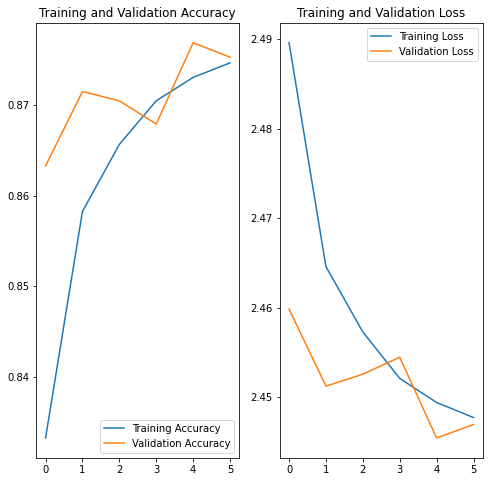

In [71]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [62]:
from google.colab.patches import cv2_imshow

In [63]:
!curl -o logo.png https://burst.shopifycdn.com/photos/the-letter-a-displayed-in-american-sign-language.jpg?width=4460&height=4460&exif=1&iptc=1&attachment=the-letter-a-displayed-in-american-sign-language.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  403k  100  403k    0     0  4798k      0 --:--:-- --:--:-- --:--:-- 4856k


(1, 200, 200, 3)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]]
[16]


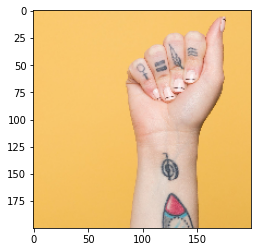

In [91]:
import numpy as np
import cv2
img = cv2.imread('logo.png', cv2.IMREAD_UNCHANGED)
img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
x=800
y=1400
h=1500
w=1500
cropimg=img[x:x+h,y:y+w]
im=cv2.resize(cropimg,(200,200))



plt.imshow(im)
batch = np.expand_dims(im,axis=0)
print(batch.shape) # (1, 28, 28)




test=model.predict(batch)
print(test)
predicted_ids = np.argmax(test, axis=-1)
print(predicted_ids)